# Исследование данных о российском кинопрокате



Нам нужно проанализировать данные по кинопрокату. У нас есть данные из двух источников Министерства культуры и сайта Кинопоиск. Данные содержат информацию о прокатных удостоверениях, рейтингах, сборах, бюджете и государственной поддержке кинофильмов.
Наша задача изучить полученные данные, посмотреть полные ли они, если есть пропуски, посмотреть можно ли их исправить. Далее, наша цель - проанализировать фильмы, оценить те, которые получили государственную поддержку.

## Получение данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# служебная строка для вывода всех столбцов
pd.set_option('display.max_columns', None)

In [6]:
mkrf_movies = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_movies.csv')

In [7]:
mkrf_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Переименуем столбец `puNumber` на `pu_number`.

In [9]:
mkrf_movies = mkrf_movies.rename(columns={'puNumber':'pu_number'})

In [10]:
mkrf_show = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_shows.csv')

In [11]:
mkrf_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Также поменяем название столбца `puNumber` таблицы `mkrf_show` на `pu_number`

In [13]:
mkrf_show = mkrf_show.rename(columns={'puNumber':'pu_number'})

Как мы видим общим в таблицах `mkrf_movies` и `mkrf_show` является столбец `pu_number`. Но, в первой таблице он имеет тип object, а во второй тип int64. Приведем эти столбцы к одному типу int64.

In [15]:
# найдем значения в столбце pu_number, которые не возможно перевести в  число
mkrf_movies.query('not pu_number.str.isnumeric()')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
type(mkrf_movies.loc[804,'pu_number'])

str

In [17]:
# для строки со значением "нет", заменим его на "0", для второй переведем его в строковый формат.
# Изменим тип данных столбца на int64.
mkrf_movies.loc[1797,'pu_number'] = '0'
mkrf_movies.loc[804,'pu_number'] = '111004112'
mkrf_movies['pu_number'] = mkrf_movies['pu_number'].astype('int64')
mkrf_movies.pu_number.dtype

dtype('int64')

Проверим, что мы изменили тип данных

In [19]:
mkrf_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Посмотрим, есть ли дубликаты в колонке `pu_number`

In [21]:
mkrf_movies['pu_number'].value_counts()

pu_number
221054410    2
221154310    2
221048915    1
121004611    1
121014411    1
            ..
121009015    1
111004115    1
211047015    1
121011015    1
124010719    1
Name: count, Length: 7484, dtype: int64

Видим, что два номера прокатного удостоверения повторились.Проверим, какие фильмы соответствуют этим прокатным удостоверениям.

In [23]:
mkrf_movies[mkrf_movies['pu_number']==221154310]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
4638,Как жениться и остаться холостым,221154310,2010-12-17T12:00:00.000Z,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия"
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17T12:00:00.000Z,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история"


In [24]:
mkrf_movies[mkrf_movies['pu_number']== 221054410]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
5067,Анализируй это!,221054410,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал"
5068,Анализируй то!,221054410,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал"


Изменим номер прокатного удостоверения во вторых повторяющихся строках, сделаем так, что визуально было видно, что с номером что-то не так.

In [26]:
for i in [4639,5068]:
        mkrf_movies.loc[i,'pu_number'] = mkrf_movies.loc[i,'pu_number'] + 1000000000000

In [27]:
mkrf_movies['pu_number'].value_counts()

pu_number
221048915    1
124000611    1
121014511    1
121014411    1
121015211    1
            ..
121008915    1
121009015    1
111004115    1
211047015    1
124010719    1
Name: count, Length: 7486, dtype: int64

Объединим таблицы в одну, оставив полностью данные из таблицы `mkrf_movies`, по столбцу `pu_number`. 

In [29]:
movies_full = mkrf_movies.merge(mkrf_show, on='pu_number', how='left')
pd.set_option('display.float_format', "{:.2f}".format) # служебная строка для вывода больших значений
movies_full.head(10)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
5,Остановился поезд,111013816,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма,NaN
6,Любовь и голуби,111007013,2013-10-18T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия",2700.00
7,Любовь и сигареты,221074614,2014-12-29T12:00:00.000Z,Художественный,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",США,Джон Туртурро,"Джон Пенотти, Джон Туртурро",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.6,"мюзикл,мелодрама,комедия",NaN
8,Отпетые мошенники.,121011416,2016-05-05T12:00:00.000Z,Художественный,"Пульсар Продюксьон, ТФ1 Фильм",Франция,Эрик Беснард,Патрис Леду,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,8.0,"комедия,криминал",NaN
9,Отпуск за свой счет,111019114,2014-12-01T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"мелодрама,комедия",NaN


In [30]:
movies_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

В результате объединения таблиц, все строки из таблицы mkrf_movies вошли в 
объединенный датафрейм.

Посмотрим на получившуюся таблицу поближе, мы видим, что у некоторых строк названия фильмов совпадают, возьмем для примера, один из них.

In [33]:
movies_full.query('title == "Особо опасен"')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


Как видим, название, тип, режиссер, продюссер совпадают, разными точно будут номера прокатных удостоверений и даты премьера фильма. Можно предположить, что это один и тот же фильм, который получал трижды прокатное удостоверение.

## Предобработка данных

### Тип данных

- Проверим типы данных в датафрейме и преобразуем их, где это необходимо.

In [37]:
movies_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Изменим тип данных в двух столбцах `show_start_date` и `ratings`.

Посмотрим, какие значения есть в столбце `ratings`.

In [40]:
movies_full['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

Мы видим, что среди значений столбца `ratings` появляются значения в процентах, мы не знаем как именно взаимосвязаны значение рейтинга и проценты, поэтому изменим тип столбца на float, при этом некорректные значения (в процентах) заменим на NaN.

In [42]:
movies_full['ratings'] = pd.to_numeric(movies_full['ratings'],errors='coerce')

В столбце `show_start_date` изменим тип на datetime.

In [44]:
movies_full['show_start_date'] = pd.to_datetime(movies_full['show_start_date']).dt.date

In [45]:
movies_full['show_start_date'].head(2)

0    2015-11-27
1    2016-09-13
Name: show_start_date, dtype: object

In [46]:
movies_full['show_start_date'] = pd.to_datetime(movies_full['show_start_date'])

In [47]:
movies_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   pu_number              7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

### Пропуски в данных

Проверим, в каких столбцах у нас есть пропуски и сколько их.

In [50]:
movies_full.isna().sum()

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

Построим график, отображающий процент пропущенных данных по столбцам.

In [52]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'missings'})
            .query('missings > 0')
            .sort_values(by = 'missings', ascending = True)
            .plot(kind = 'barh', figsize = (19,6),legend = False,fontsize = 16)
            .set_title('Пропущенные значения в столбцах, %' + "\n", fontsize=18, color='Black')
        );    
    except:
        print('Ошибка! или пропусков нет')

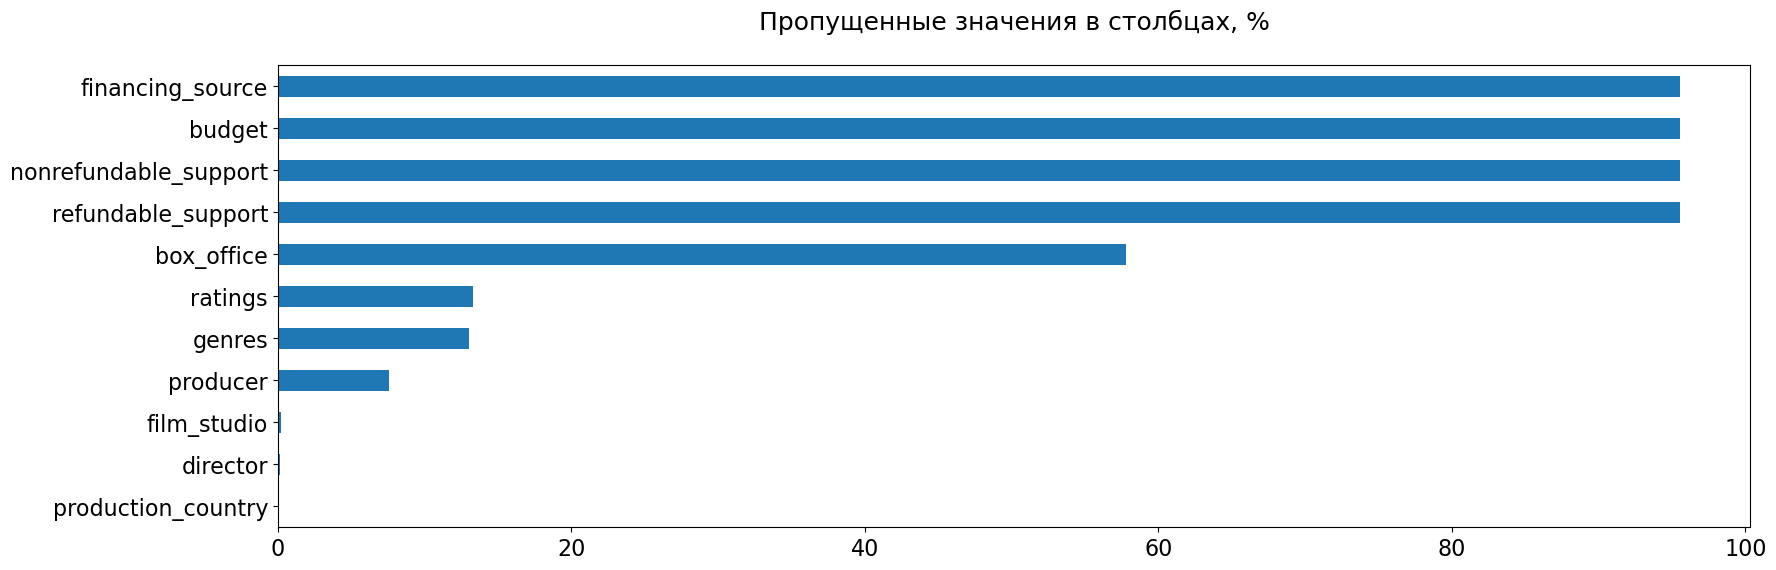

In [53]:
pass_value_barh(movies_full)

Как видим в четырех столбцах одинаковое огромное количество пропусков (около 95% данных), удалять такие строки нельзя, так как мы потеряем 95% данных, заполнять их тоже невозможно, так как нам неизвестны ни источники государственного финансирования, ни  бюджет, ни объемы государственной финансовой поддержки как для иностранных фильмов, так и для фильмов, выпущенных в СССР. Эти данные у нас есть только для фильмов производства России.

В столбце `production_country` восстановить два пропущенных значения достаточно просто, нам лишь нужно посмотреть на остальные данные по этим строкам.

In [55]:
movies_full[movies_full['production_country'].isna()==True]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.20,"детский,комедия",194527.00
4441,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN


Фильмы современные 2010 и 2016 года выпуска, выпускались они у нас в России, поэтому заменим пропуски на значение "Россия".

In [57]:
movies_full.loc[(movies_full['production_country'].isna()),'production_country'] = 'Россия'

В столбце `director` всего 9 пропусков, посмотрим, какие данные в этих строках.

In [59]:
movies_full[movies_full['director'].isna()==True]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44350.00
1735,Помпеи. Британский музей,126003413,2013-09-11,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.90,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.70,"концерт,музыка",NaN


Как видим в основном, это записи концертов и шоу, так что заполним пропуски в этих строках в столбце `director` строкой 'unknown'.

In [61]:
movies_full['director'] = movies_full['director'].fillna('unknown')
movies_full['director'].isna().sum()

0

Аналогично поступим со столбцами `genres`, `film_studio`, `producer`.

In [63]:
movies_full[movies_full['film_studio'].isna()==True]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.30,комедия,NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,Россия,unknown,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.00,"мультфильм,комедия",NaN
6105,Значит любит,111013818,2018-08-10,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6181,Несейка. Младшая дочь,112007018,2018-09-01,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6379,Ян Антонышев,112011818,2018-11-15,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6380,Ян Антонышев,112011918,2018-11-15,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399,Доживем до каникул?..,111021918,2018-11-15,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,41225.00
6485,До и После,112014418,2018-12-05,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.90,"драма,криминал,детектив",NaN
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6497,Мой папа Чингисхан,112014918,2018-12-06,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
columns_to_replace = ['genres', 'film_studio', 'producer']
for column in columns_to_replace:
    movies_full[column] = movies_full[column].fillna('unknown') 
    print(movies_full[column].isna().sum())

0
0
0


Рассмотрим, какие значения есть в столбце `financing_sourse`.

In [66]:
movies_full['financing_source'].unique()

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

Заменим пропуски в этом столбце на пустую строку.

In [68]:
movies_full['financing_source'] = movies_full['financing_source'].fillna('')
movies_full['financing_source'].isna().sum()

0

Посмотрим, где и какие пропуски у нас остались.

In [70]:
movies_full.isna().sum()

title                       0
pu_number                   0
show_start_date             0
type                        0
film_studio                 0
production_country          0
director                    0
producer                    0
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source            0
ratings                   996
genres                      0
box_office               4328
dtype: int64

### Проверим датафрейм на дубликаты

Проверим, есть ли в наших данных полные дубликаты.

In [73]:
movies_full.duplicated().sum()

0

Явных дубликатов у нас нет, но мы помним, что у нас есть фильмы, имеющие одинаковые названия, режиссеров, продюссеров и т.д., но при этом имеющих разные прокатные удостоверения и разные данные по дате премьеры фильма. Таким  образом, мы имеем неявные дубликаты. Возможно. они появились из-за того, что фильм несколько раз получал прокатное удостоверение (в случае окончания действия одного и получения нового, либо при изменении правообладателя) и дата премьеры - дата первого показа после получения прокатного удостоверения. Тогда, следует предположить, что при удалении дубликатов мы должны просуммировать суммы сборов, так как они относятся к конкретному прокатному удостоверению.

Для того, чтобы удалить неявные дубликаты, мы создадим новый столбец `hash`, в котором будет указана уникальная информация 
по фильму: название, тип фильма, студия-производитель, страна-производитель, режиссер, продюссер и жанр.
    

In [76]:
def canonical_value(value, name = ''):
    """Создадим функцию, которая обрабатывает входящее значение:
    - если значение NaN, то функция возвращает пустую строку  
    - если значение не NaN, то функция переводит его в строку, в нижний регистр, убирает
    пробелы, точки, подчеркивания и восклицательные знаки в начале и конце значения    
    а также убирает все пробелы
    """
   
    if (pd.isnull(value)):              
        return ''
    else:                                                          
        value = str(value)              
        value = value.lower()           
        value =  value.strip(' ._!')   
        value = value.replace(' ','')
        return value

movies_full['hash'] = ''

for column in ['title','type','film_studio','production_country','director','producer', 'genres']:
    movies_full['hash'] += movies_full[column].apply(canonical_value)    


Также создадим столбец `rental`показывающий был фильм в прокате или нет: если фильм был в прокате, то значение 1, если нет - то 0.

In [78]:
def was_rental(value):
    if (pd.isnull(value)):
        return 0
    else:
        return 1
for i in range(movies_full.shape[0]):
        movies_full.loc[i,'rental'] = was_rental(movies_full.loc[i,'box_office'])    

In [79]:
movies_full.query('box_office == 0 & rental == 1')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,hash,rental
66,Анна Павлова,111011013,2013-12-19,Художественный,"совместное производство Киностудия ""Мосфильм"",...","СССР, Франция, Англия, Куба, ГДР",Эмиль Лотяну,unknown,«6+» - для детей старше 6 лет,NaN,NaN,NaN,,7.70,"драма,биография,музыка",0.00,аннапавловахудожественныйсовместноепроизводств...,1.00
237,Подранки,111007613,2013-10-18,Художественный,"Киностудия ""Мосфильм""",СССР,Н.Губенко,unknown,«12+» - для детей старше 12 лет,NaN,NaN,NaN,,8.20,драма,0.00,"подранкихудожественныйкиностудия""мосфильм""ссср...",1.00
596,Запах вереска,111003012,2012-05-23,Художественный,"ООО ""Студия РИМ""",Россия,А.Магомедов,"М.Балашова, Е.Миронов",«16+» - для детей старше 16 лет,NaN,NaN,NaN,,6.30,комедия,0.00,"запахверескахудожественныйооо""студиярим""россия...",1.00
914,В тумане /По одноименной повести Василя Быкова/,121027712,2012-11-07,Художественный,"Ма Йа Де Фикшн, Лемминг Филм, Беларусьфильм, Д...",Германия - Нидерланды - Беларусь - Россия - Ла...,Сергей Лозница,Хайно Декерт,«12+» - для детей старше 12 лет,NaN,NaN,NaN,,6.50,"драма,военный,история",0.00,втумане/поодноименнойповестивасилябыкова/худож...,1.00
932,Письмо для Момо,124002912,2012-10-25,Анимационный,"Кадокава Пикчерз, Продакшнз И Джи, Токио Броад...",Япония,Окиура Хироюки,"Хироюки Икеда, Митсухиса Ишикава, Кацзуя Хамана",«12+» - для детей старше 12 лет,NaN,NaN,NaN,,7.40,"аниме,мультфильм,драма",0.00,"письмодлямомоанимационныйкадокавапикчерз,прода...",1.00
933,Летние войны,124002812,2012-10-25,Анимационный,"Медхауз, Ниппон Телевижн Нетуорк Корпорейшн, К...",Япония,Мамору Хосода,"Такафуми Ватанабэ, Такуя Ито, Сэйдзи Окуда, Юи...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,,7.70,"аниме,мультфильм,фантастика",0.00,"летниевойныанимационныймедхауз,ниппонтелевижнн...",1.00
976,Гарегин Нжде,131000213,2013-04-23,Художественный,"Эй Джи Кей Продакшнз, Пан Армениан Медиа Групп",Армения,Грач Кешишян,Грач Кешишян,«12+» - для детей старше 12 лет,NaN,NaN,NaN,,7.90,биография,0.00,"гарегиннждехудожественныйэйджикейпродакшнз,пан...",1.00
1126,Марафон,111006712,2012-12-18,Художественный,"ООО ""Синема Арт Студио""",Россия,К.Оганесян,К.Оганесян,«16+» - для детей старше 16 лет,NaN,NaN,NaN,,5.50,"комедия,мелодрама",0.00,"марафонхудожественныйооо""синемаартстудио""росси...",1.00
1387,Экзамен для двоих /По роману Джин Ханфф Корелитц/,121014613,2013-06-11,Художественный,Депф оф Филд,США,Пол Вайц,"Пол Вайц, Керри Кохански, Эндрю Миано",«12+» - для детей старше 12 лет,NaN,NaN,NaN,,5.80,"мелодрама,комедия,драма",0.00,экзамендлядвоих/поромануджинханффкорелитц/худо...,1.00
1559,Последняя любовь мистера Моргана /По роману Фр...,121002614,2014-02-11,Художественный,"Камински Штим Фильм, Бавариа Пикчерз, Сенатор ...",Германия - Бельгия - США -Франция,Сандра Неттельбек,"Франк Камински, Астрид Камке, Филипп Кройцер, ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,,6.90,драма,0.00,последняялюбовьмистераморгана/поромануфрансуаз...,1.00


У нас есть 24 строчки, в которых фильм был в прокате, но сумма сборов равна 0.

In [81]:
title_list = movies_full['hash'].value_counts()
title_list

hash
деньсвятоговалентинахудожественныйуорнербразерс,ньюлайнсинема,уэйнрайс,карцинтертейнментсшагарримаршаллсэмюэлдж.браунмелодрама,комедия                                                                                                                                                            5
шерлокхолмсхудожественныйлинпикчерз,сильверпикчерз,виладжроадшоупикчерз,уигрэмпродакшнзсша-германиягайричисьюзандоуни,дэнлин,джоелсильвер,лайонелуигрэмбоевик,приключения,триллер                                                                                                                 4
женапутешественникавовременихудожественныйуорнербразерс,ньюлайнсинема,плэнбисшаробертшвенткедедегарднер,никуэкслерфантастика,фэнтези,драма                                                                                                                                                        4
небратьживым/покнигерадживачандрасекарана/художественныйюниверсалпикчерз,студиоканал,рилейтивитимедиа,уоркингтайтл,анте

In [82]:
movies_full[movies_full['hash']=='сёстры(2015)художественныйлитлстренджерсшаджейсонмурбрайанбелл,джейроуч,тинафейужасы,триллер,детектив']

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,hash,rental
3179,Сёстры (2015),221029216,2016-06-21,Художественный,Литл Стренджер,США,Джейсон Мур,"Брайан Белл, Джей Роуч, Тина Фей",«18+» - запрещено для детей,NaN,NaN,NaN,,6.90,"ужасы,триллер,детектив",NaN,сёстры(2015)художественныйлитлстренджерсшаджей...,0.00
3180,Сёстры (2015),121025815,2015-12-23,Художественный,Литл Стренджер,США,Джейсон Мур,"Брайан Белл, Джей Роуч, Тина Фей",«18+» - запрещено для детей,NaN,NaN,NaN,,6.90,"ужасы,триллер,детектив",12530627.68,сёстры(2015)художественныйлитлстренджерсшаджей...,1.00


Создадим новую таблицу movies_full_new,  в которой мы сгруппируем данные таблицы movies_full по столбцу `hash`.

Далее удалим дубликаты по столбцу `hash` в таблице movies_full.
Сбросим индексы после удаления строк, объединим таблицы по столбцу `hash`,удалим старые данные.

In [84]:
movies_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   pu_number              7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7486 non-null   object        
 5   production_country     7486 non-null   object        
 6   director               7486 non-null   object        
 7   producer               7486 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       7486 non-null   object        
 13  rat

In [85]:

movies_full_new = movies_full.groupby('hash').agg({'box_office':'sum','refundable_support':'mean','nonrefundable_support':'mean','budget':'mean', 'financing_source':'sum','rental':'max'}).reset_index()

movies_full = movies_full.drop_duplicates(subset=['hash'], keep='last')

movies_full = movies_full.reset_index(drop=True)

movies_total = movies_full.merge(movies_full_new, on='hash', how='left')
movies_total.drop(['refundable_support_x','nonrefundable_support_x','financing_source_x', 'budget_x','box_office_x','rental_x'], axis=1, inplace=True)
movies_total = movies_total.rename(columns={'refundable_support_y':'refundable_support','nonrefundable_support_y':'nonrefundable_support',
                                           'financing_source_y':'financing_source', 'budget_y':'budget',
                                            'box_office_y':'box_office','rental_y':'rental'})
movies_total.head()


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental
0,Открытый простор,221048915,2015-11-27,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.20,"боевик,драма,мелодрама","открытыйпросторхудожественныйтачстоунпикчерз,к...",0.00,NaN,NaN,NaN,,0.00
1,Особо важное задание,111013716,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,unknown,«6+» - для детей старше 6 лет,6.60,"драма,военный","особоважноезаданиехудожественныйкиностудия""мос...",0.00,NaN,NaN,NaN,,0.00
2,Особо опасен,221030815,2015-07-29,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.80,"фантастика,боевик,триллер","особоопасенхудожественныйюниверсалпикчерз,кикс...",0.00,NaN,NaN,NaN,,0.00
3,Остановился поезд,111013816,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,unknown,«6+» - для детей старше 6 лет,7.70,драма,"остановилсяпоездхудожественныйкиностудия""мосфи...",0.00,NaN,NaN,NaN,,0.00
4,Любовь и голуби,111007013,2013-10-18,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,unknown,«12+» - для детей старше 12 лет,8.30,"мелодрама,комедия","любовьиголубихудожественныйкиностудия""мосфильм...",2700.00,NaN,NaN,NaN,,1.00


In [86]:
movies_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6801 entries, 0 to 6800
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  6801 non-null   object        
 1   pu_number              6801 non-null   int64         
 2   show_start_date        6801 non-null   datetime64[ns]
 3   type                   6801 non-null   object        
 4   film_studio            6801 non-null   object        
 5   production_country     6801 non-null   object        
 6   director               6801 non-null   object        
 7   producer               6801 non-null   object        
 8   age_restriction        6801 non-null   object        
 9   ratings                5814 non-null   float64       
 10  genres                 6801 non-null   object        
 11  hash                   6801 non-null   object        
 12  box_office             6801 non-null   float64       
 13  ref

In [87]:
movies_total.query('budget.isna()==False')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental
1053,Пока еще жива,111005313,2013-10-11,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,8.10,"драма,мелодрама",покаещеживахудожественныйаносодействияразвитию...,365353.60,0.00,26500000.00,79411900.00,Министерство культуры,1.00
1202,Бесславные придурки,111003314,2014-03-28,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,NaN,unknown,"бесславныепридуркихудожественныйооо""компания""а...",28140.00,0.00,26000000.00,37142857.00,Министерство культуры,1.00
1245,Невидимки,111004213,2013-09-10,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,5.30,"комедия,фантастика","невидимкихудожественныйооо""компания""реал-дакот...",19957031.50,0.00,107847945.00,176023490.00,Фонд кино,1.00
1267,БЕРЦЫ,111004314,2014-05-05,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,4.20,драма,"берцыхудожественныйооо""студия""пассажир""россияе...",55917.50,0.00,28000000.00,40574140.00,Министерство культуры,1.00
1512,Братья Ч,111004414,2014-04-23,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,6.40,драма,"братьячхудожественныйооо""студия""пассажир""росси...",232100.00,0.00,25000000.00,40015122.00,Министерство культуры,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6779,Союз спасения,111022019,2019-12-26,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,6.00,"история,биография,драма","союзспасенияхудожественныйзао""дирекциякино""рос...",717703185.53,100000000.00,400000000.00,980000000.00,Фонд кино,1.00
6781,Иван Царевич и Серый Волк 4,114005019,2019-12-20,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,6.70,"мультфильм,приключения,семейный","иванцаревичисерыйволк4анимационныйооо""студияан...",501069235.00,100000000.00,0.00,190000000.00,Фонд кино,1.00
6789,Вторжение,111022519,2019-12-23,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,5.70,"фантастика,боевик","вторжениехудожественныйооо""артпикчерсстудия"",о...",0.00,100000000.00,400000000.00,944000000.00,Фонд кино,0.00
6791,Я свободен,111023019,2019-12-26,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,5.90,драма,"ясвободенхудожественныйао""тпо""киностудияим.м.г...",0.00,0.00,30000000.00,46154000.00,Министерство культуры,0.00


###  Изучим категориальные значения

В столбцах со строковыми данными легко можно поставить лишний пробел в начале или конце строки, визуально это будет не заментно, но скажется на данных. Например, рассмотрим значения столбца `type`.

In [90]:
movies_total['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

Как видим в начале строк есть пробелы, удалим их.

In [92]:
movies_total['type'] = movies_total['type'].str.strip(' ')
movies_total['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

Проделаем тоже самое для всех колонок с категориальными данными

In [94]:
for column in ['title','type','film_studio','production_country','director','producer', 'genres']:
            movies_total[column] = movies_total[column].str.strip(' ')  

In [95]:
movies_total['production_country'].unique()

array(['США', 'СССР', 'Франция', 'СССР, Венгрия',
       'Германия-Великобритания', 'Великобритания - Италия',
       'Чехословакия', 'Новая Зеландия', 'Канада - Франция - Испания',
       'Великобритания', 'США - Германия', 'Франция - Мексика - США',
       'Россия, Казахстан, США', 'СССР, Швеция',
       'СССР, Франция, Англия, Куба, ГДР', 'Германия',
       'Великобритания-США-Германия-КНР',
       'СССР, ЧССР, Западный Берлин, ПНР', 'СССР, Италия', 'Гонконг, КНР',
       'США - Франция', 'США - Япония - Франция - Великобритания',
       'Гонконг - Сингапур - Таиланд - Великобритания', 'США-Канада',
       'Франция - Италия - Великобритания - США',
       'Ирландия-Великобритания-Германия', 'США - Великобритания',
       'Чехия', 'СССР, Финляндия', 'США-Франция-Великобритания-Австрия',
       'США - Бельгия', 'США - Ирландия - Великобритания',
       'Люксембург - Нидерланды - Испания - Великобритания - США - Италия',
       'Великобритания - Франция - США', 'Новая Зеландия - США',


### Проверим количественные значения

В столбце `budget` указан полный объем государственной поддержки, поэтому значения в этом столбце должны быть больше или равны сумме значений столбцов `refundable_support` и `nonrefundable_support`. 

In [98]:
movies_total.query('budget<refundable_support+ nonrefundable_support')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental
1751,14+,111023614,2014-12-19,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,6.60,мелодрама,"14+художественныйооокиностудия""сентябрь""россия...",10234016.10,0.00,23000000.00,0.00,"Министерство культуры, Фонд кино",1.00
1756,Дуxless 2,111000415,2015-01-26,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,6.60,драма,"дуxless2художественныйооо""киностудия""слово"",оо...",446163511.00,0.00,75000000.00,0.00,Фонд кино,1.00
2130,Воин (2015),111017315,2015-09-28,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,7.80,"боевик,драма,криминал","воин(2015)художественныйооо""форпостпродакшн"",о...",196572438.40,10000000.00,70000000.00,0.00,Фонд кино,1.00
2188,Бармен.,111009615,2015-05-26,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,6.20,"комедия,фэнтези","барменхудожественныйао""вайтмедиа"",ооо""артпикче...",67418974.80,20000000.00,0.00,0.00,Фонд кино,1.00
2262,Савва. Сердце воина,114001715,2015-07-21,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«6+» - для детей старше 6 лет,4.60,"мультфильм,приключения,фэнтези","савва.сердцевоинаанимационныйооо""глюкозапродак...",184487551.40,60000000.00,100000000.00,0.00,Фонд кино,1.00
2324,Тряпичный союз,111010215,2015-06-08,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,6.30,"комедия,драма","тряпичныйсоюзхудожественныйооо""кинокомпания""ко...",1957738.51,0.00,59000000.00,0.00,Фонд кино,1.00
2420,Срочно выйду замуж,111017115,2015-09-30,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,5.10,"комедия,мелодрама","срочновыйдузамужхудожественныйао""вайтмедиа"",оо...",72937783.20,0.00,35000000.00,0.00,Фонд кино,1.00
2500,Помню - не помню!,111004916,2016-03-01,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«12+» - для детей старше 12 лет,4.30,комедия,"помню-непомнюхудожественныйооо""кинофирма""росси...",15362931.43,0.00,6000000.00,0.00,Министерство культуры,1.00
2665,Любовь с ограничениями,111008216,2016-04-29,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,6.30,"комедия,мелодрама","любовьсограничениямихудожественныйао""вайтмедиа...",70299052.00,19000000.00,51000000.00,0.00,Фонд кино,1.00
3155,Притяжение (2016),111018116,2016-12-16,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,5.60,фантастика,"притяжение(2016)художественныйооо""водород2011""...",1038321489.00,0.00,250000000.00,0.00,Фонд кино,1.00


У нас 17 строк, в которых бюджет меньше суммы государственной поддержки. заменим значения в этих строках в столбце `budget` на пропуски.

In [100]:
movies_total['budget'].isna().sum()

6469

In [101]:
movies_total.loc[movies_total["budget"] <= movies_total["refundable_support"] + movies_total["nonrefundable_support"],'budget'] = np.nan

In [102]:
movies_total['budget'].isna().sum()

6486

Проверим, что лишних нулей в столбце `box_office` не приобрели.

In [104]:
display(movies_total.query('box_office == 0 & rental == 1')['box_office'].count())

24

In [105]:
movies_total['refundable_support'].describe()

count         332.00
mean     11864457.83
std      24916555.26
min             0.00
25%             0.00
50%             0.00
75%      15000000.00
max     180000000.00
Name: refundable_support, dtype: float64

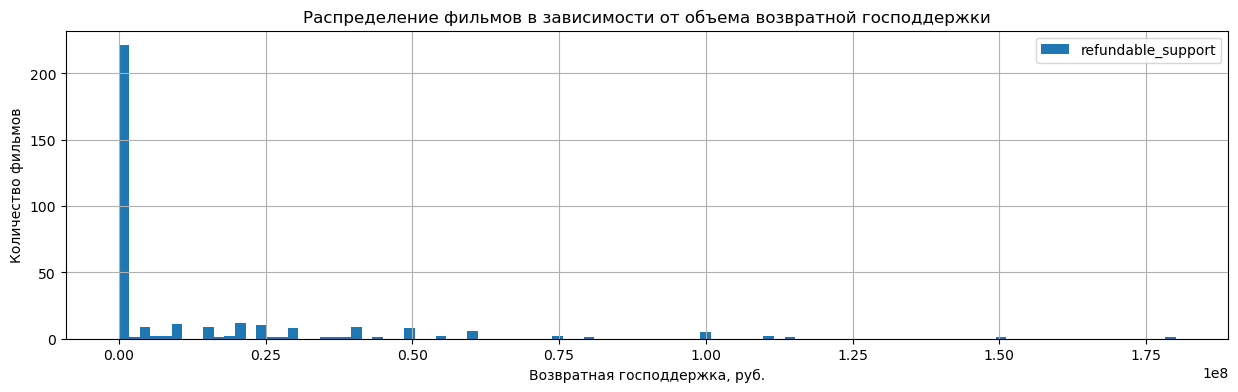

In [106]:
movies_total.plot(y='refundable_support', kind='hist', bins=100, range=(0,180000000), grid=True, 
                  xlabel='Возвратная господдержка, руб.', ylabel='Количество фильмов', 
                  title='Распределение фильмов в зависимости от объема возвратной господдержки', figsize=(15,4));

In [107]:
movies_total.query('refundable_support ==0')['refundable_support'].count()

221

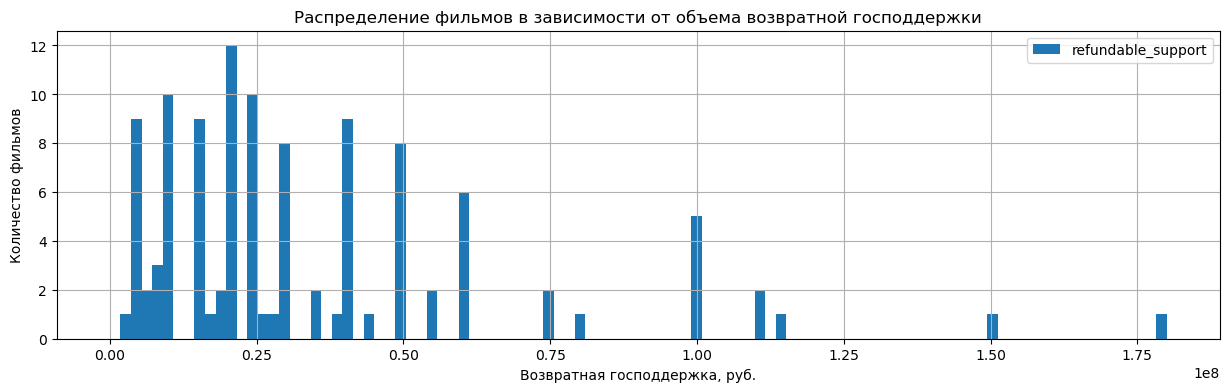

In [108]:
movies_total.plot(y='refundable_support', kind='hist', bins=100, range=(1,180000000), grid=True, 
                  xlabel='Возвратная господдержка, руб.', ylabel='Количество фильмов', 
                  title='Распределение фильмов в зависимости от объема возвратной господдержки', figsize=(15,4));

Большинство фильмов, получивших возвратную господдержку, получили не более 50 миллионов рублей.

In [110]:
movies_total['nonrefundable_support'].describe()

count         332.00
mean     48980988.89
std      59980117.92
min             0.00
25%      25000000.00
50%      30000000.00
75%      40375000.00
max     400000000.00
Name: nonrefundable_support, dtype: float64

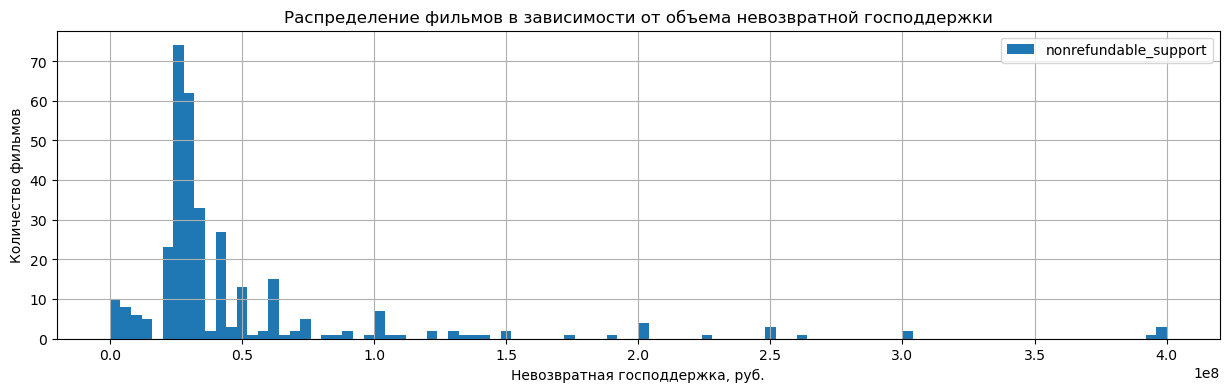

In [111]:
movies_total.plot(y='nonrefundable_support', kind='hist', bins=100, range=(0,400000000), grid=True, 
                  xlabel='Невозвратная господдержка, руб.', ylabel='Количество фильмов', 
                  title='Распределение фильмов в зависимости от объема невозвратной господдержки', figsize=(15,4));

Большинство фильмов, получивших невозвратную господдержку, получили от 25 до 50 миллионов рублей.

In [113]:
movies_total.query('nonrefundable_support>200000000')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental
2338,Он - Дракон,111017915,2015-10-14,Художественный,"ООО ""ТаББаК""",Россия,И.Джендубаев,Т.Бекмамбетов,«6+» - для детей старше 6 лет,6.80,фэнтези,"он-драконхудожественныйооо""таббак""россияи.джен...",110171448.50,0.00,250000000.00,360000000.00,Фонд кино,1.00
2545,Экипаж .,111005416,2016-03-21,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,Н.Лебедев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,7.60,"драма,триллер,приключения","экипажхудожественныйооо""студия""тритэ""никитымих...",1402255390.00,50000000.00,392104482.00,635283867.00,Фонд кино,1.00
2943,Дуэлянт,111015416,2016-09-14,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,А.Мизгирев,"А.Роднянский, С.Мелькумов",«16+» - для детей старше 16 лет,6.60,драма,"дуэлянтхудожественныйооо""нон-стоппродакшн""росс...",364285139.60,150000000.00,300000000.00,684200536.00,Фонд кино,1.00
3155,Притяжение (2016),111018116,2016-12-16,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,5.60,фантастика,"притяжение(2016)художественныйооо""водород2011""...",1038321489.00,0.00,250000000.00,NaN,Фонд кино,1.00
4823,Салют-7,111006917,2017-10-01,Художественный,"ООО ""Лемон Филмз Студио""",Россия,К.Шипенко,"С.Сельянов, Б.Бакурадзе, А.Златопольский",«12+» - для детей старше 12 лет,7.40,"драма,приключения,триллер","салют-7художественныйооо""лемонфилмзстудио""росс...",752679777.00,0.00,225000000.00,493733957.00,Фонд кино,1.00
4890,Легенда о Коловрате,111007617,2017-11-30,Художественный,"ООО ""Продюсерский центр ИВАН""",Россия,И.Шурховецкий,"ООО ""Централ Партнершип"", АО ""Тел...",«12+» - для детей старше 12 лет,6.40,"история,боевик,фэнтези","легендаоколовратехудожественныйооо""продюсерски...",590405065.00,100000000.00,250000000.00,500012729.00,Фонд кино,1.00
4974,Движение вверх,111011817,2017-12-21,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,7.50,"спорт,драма","движениевверххудожественныйооо""студия""тритэ""ни...",2779686144.00,0.00,400000000.00,590192191.00,Фонд кино,1.00
5147,Тренер,111003218,2018-04-19,Художественный,"ООО ""ДК интертеймент"", ООО ""Киностудия ""Слово""...",Россия,Д.Козловский,"Д.Козловский, П.Ануров, Л.Верещагин, А.Златопо...",«12+» - для детей старше 12 лет,6.80,"драма,спорт","тренерхудожественныйооо""дкинтертеймент"",ооо""ки...",820528005.21,0.00,260000000.00,390191139.00,Фонд кино,1.00
6202,Девятая,111007019,2019-09-19,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,Н.Хомерики,"С.Мелькумов, А.Роднянский",«16+» - для детей старше 16 лет,5.80,"детектив,триллер,криминал","девятаяхудожественныйооо""нон-стоппродакшн""росс...",55876887.40,0.00,300000000.00,453704666.00,Фонд кино,1.00
6779,Союз спасения,111022019,2019-12-26,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,6.00,"история,биография,драма","союзспасенияхудожественныйзао""дирекциякино""рос...",717703185.53,100000000.00,400000000.00,980000000.00,Фонд кино,1.00


Фильмы, получившие невозвратную господдержку в размере более 200 миллионов рублей, которая перекрывает больше половины бюджета, профинансированы Фондом кино.

In [115]:
movies_total['budget'].describe()

count          315.00
mean     134096082.35
std      191226039.63
min       14462464.00
25%       46153866.50
50%       73379554.00
75%      150004286.50
max     2305074303.00
Name: budget, dtype: float64

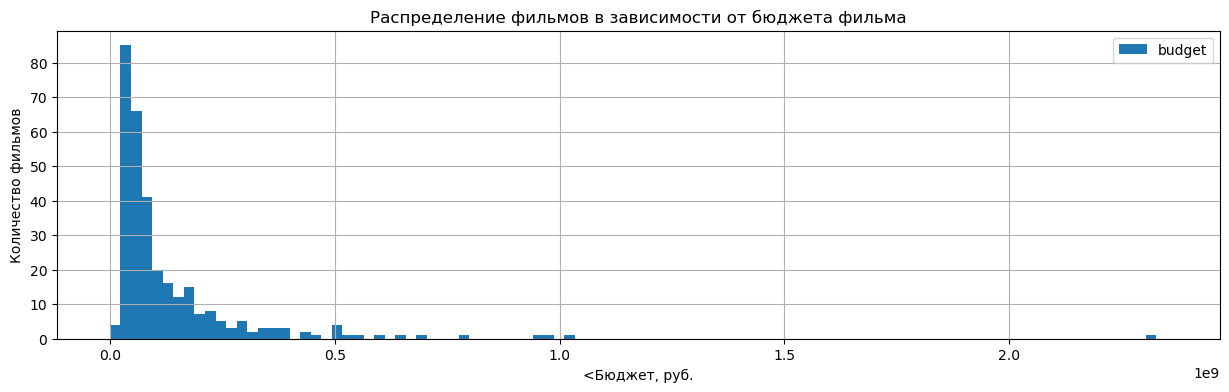

In [116]:
movies_total.plot(y='budget', kind='hist', bins=100, range=(0,2350000000), grid=True, 
                  xlabel='<Бюджет, руб.', ylabel='Количество фильмов', 
                  title='Распределение фильмов в зависимости от бюджета фильма', figsize=(15,4));

In [117]:
movies_total.query('budget>1000000000')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental
4758,Матильда,111005717,2017-08-17,Художественный,"ООО ""ТПО ""РОК"", ООО ""Матильда""",Россия,А.Учитель,"А.Учитель, А.Достман, В.Винокур",«16+» - для детей старше 16 лет,7.70,"фэнтези,комедия,семейный","матильдахудожественныйооо""тпо""рок"",ооо""матильд...",511775548.00,110000000.00,190000000.00,1032905957.00,Фонд кино,1.00
6429,Тайна Печати Дракона,111012819,2019-09-12,Художественный,"ООО ""Кинокомпания ""СТВ""; ООО ""РФГ Корп""; ООО ""...",Россия-Китай,О.Степченко,"С.Сельянов, А.Петрухин",«6+» - для детей старше 6 лет,5.80,"приключения,фэнтези","тайнапечатидраконахудожественныйооо""кинокомпан...",333597059.59,180000000.00,90000000.00,2305074303.00,Фонд кино,1.00


Большая часть фильмов имеют бюджет не более 300 миллионов рублей. Фильмы с бюджетом больше 1 миллиарда рублей провалились в прокате.

In [119]:
movies_total.query('box_office>0')['box_office'].describe()

count         3105.00
mean      77784129.62
std      242186836.45
min             40.00
25%         128650.00
50%        2486673.00
75%       25177029.87
max     3073568690.79
Name: box_office, dtype: float64

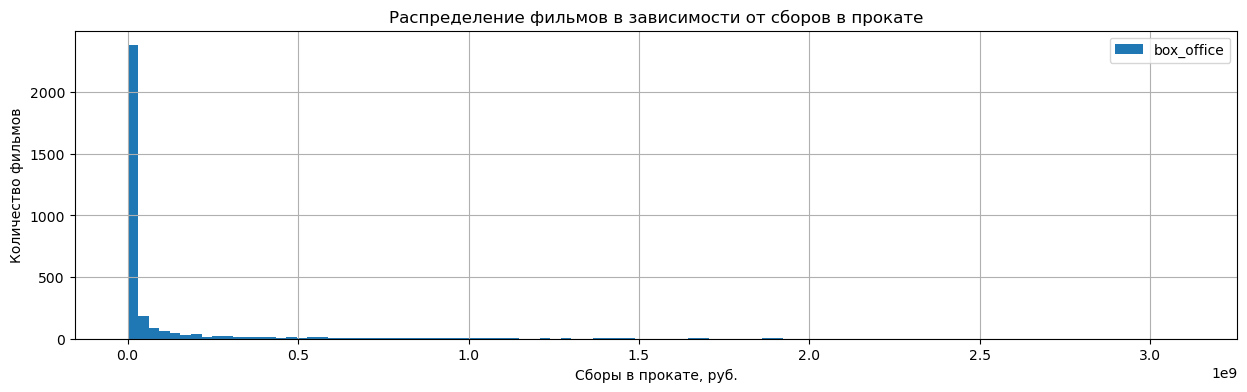

In [120]:
movies_total.query('box_office>0').plot(y='box_office', kind='hist', bins=100, range=(0,3100000000), grid=True, 
                                        xlabel='Сборы в прокате, руб.', ylabel='Количество фильмов', 
                                        title='Распределение фильмов в зависимости от сборов в прокате', figsize=(15,4));

Посмотрим поближе на значения около нуля.

In [122]:
movies_total.query('0<box_office<1000000')['box_office'].count()

1205

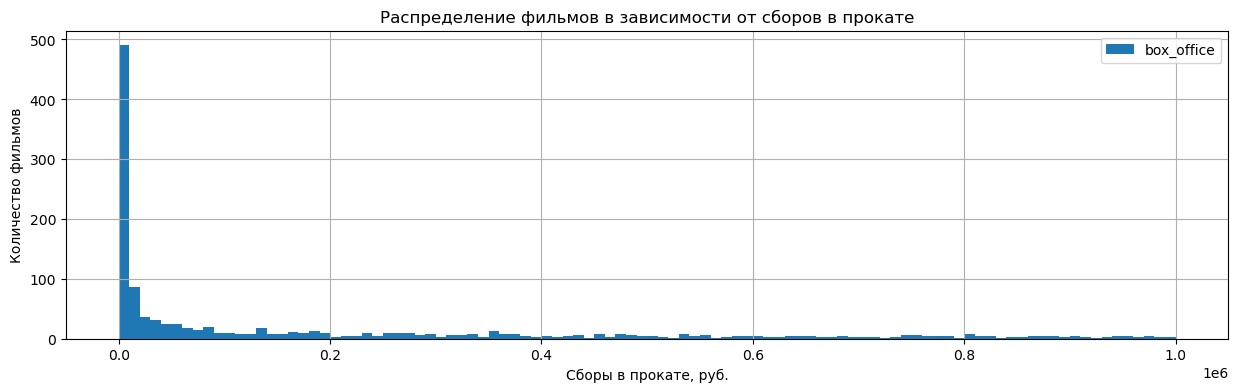

In [123]:
movies_total.query('box_office>0').plot(y='box_office', kind='hist', bins=100, range=(0,1000000), grid=True, 
                                        xlabel='Сборы в прокате, руб.', ylabel='Количество фильмов', 
                                        title='Распределение фильмов в зависимости от сборов в прокате', figsize=(15,4));

У нас 1205 фильмов со значениями менее 1 000 000 руб., причем большая часть из них имеет сборы менее 100 000 руб.

In [125]:
movies_total.query('0<box_office<10000')['box_office'].count()

490

490 фильмов имеют сборы меньше 10 000 руб. Это возможно, если при заполнении таблицы, данные были внесены в миллионах рублей или  была допущена еще какая-то ошибка.

### Добавление новых столбцов

- Создадим столбец с информацией о годе проката. 

In [206]:
movies_total['show_start_year'] = movies_total['show_start_date'].dt.year
movies_total.head()

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental,show_start_year
0,Открытый простор,221048915,2015-11-27,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.20,"боевик,драма,мелодрама","открытыйпросторхудожественныйтачстоунпикчерз,к...",0.00,NaN,NaN,NaN,,0.00,2015
1,Особо важное задание,111013716,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,unknown,«6+» - для детей старше 6 лет,6.60,"драма,военный","особоважноезаданиехудожественныйкиностудия""мос...",0.00,NaN,NaN,NaN,,0.00,2016
2,Особо опасен,221030815,2015-07-29,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.80,"фантастика,боевик,триллер","особоопасенхудожественныйюниверсалпикчерз,кикс...",0.00,NaN,NaN,NaN,,0.00,2015
3,Остановился поезд,111013816,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,unknown,«6+» - для детей старше 6 лет,7.70,драма,"остановилсяпоездхудожественныйкиностудия""мосфи...",0.00,NaN,NaN,NaN,,0.00,2016
4,Любовь и голуби,111007013,2013-10-18,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,unknown,«12+» - для детей старше 12 лет,8.30,"мелодрама,комедия","любовьиголубихудожественныйкиностудия""мосфильм...",2700.00,NaN,NaN,NaN,,1.00,2013


- Создадим два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

In [209]:
def splitter(column, new_column):
    for i in range(movies_total.shape[0]):
        movies_total.loc[i,new_column] = str(movies_total.loc[i,column]).split(',')[0]
       

In [211]:

splitter('director','first_director')
splitter('genres','main_genre')
movies_total.head(5)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,ratings,genres,hash,box_office,refundable_support,nonrefundable_support,budget,financing_source,rental,show_start_year,first_director,main_genre
0,Открытый простор,221048915,2015-11-27,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.20,"боевик,драма,мелодрама","открытыйпросторхудожественныйтачстоунпикчерз,к...",0.00,NaN,NaN,NaN,,0.00,2015,Кевин Костнер,боевик
1,Особо важное задание,111013716,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,unknown,«6+» - для детей старше 6 лет,6.60,"драма,военный","особоважноезаданиехудожественныйкиностудия""мос...",0.00,NaN,NaN,NaN,,0.00,2016,Е.Матвеев,драма
2,Особо опасен,221030815,2015-07-29,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.80,"фантастика,боевик,триллер","особоопасенхудожественныйюниверсалпикчерз,кикс...",0.00,NaN,NaN,NaN,,0.00,2015,Тимур Бекмамбетов,фантастика
3,Остановился поезд,111013816,2016-09-13,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,unknown,«6+» - для детей старше 6 лет,7.70,драма,"остановилсяпоездхудожественныйкиностудия""мосфи...",0.00,NaN,NaN,NaN,,0.00,2016,В.Абдрашитов,драма
4,Любовь и голуби,111007013,2013-10-18,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,unknown,«12+» - для детей старше 12 лет,8.30,"мелодрама,комедия","любовьиголубихудожественныйкиностудия""мосфильм...",2700.00,NaN,NaN,NaN,,1.00,2013,В.Меньшов,мелодрама


- Посчитаем какую долю от общего бюджета фильма составляет государственная поддержка.

In [217]:
movies_total['support'] = (movies_total['refundable_support'] + movies_total['nonrefundable_support'])
movies_total['gu_support'] = round((movies_total['support']) / movies_total['budget'] * 100, 2)
movies_total[['title','budget','gu_support']].query('budget > 0').head()

,title,budget,gu_support
1053,Пока еще жива,79411900.00,33.37
1202,Бесславные придурки,37142857.00,70.00
1245,Невидимки,176023490.00,61.27
1267,БЕРЦЫ,40574140.00,69.01
1512,Братья Ч,40015122.00,62.48


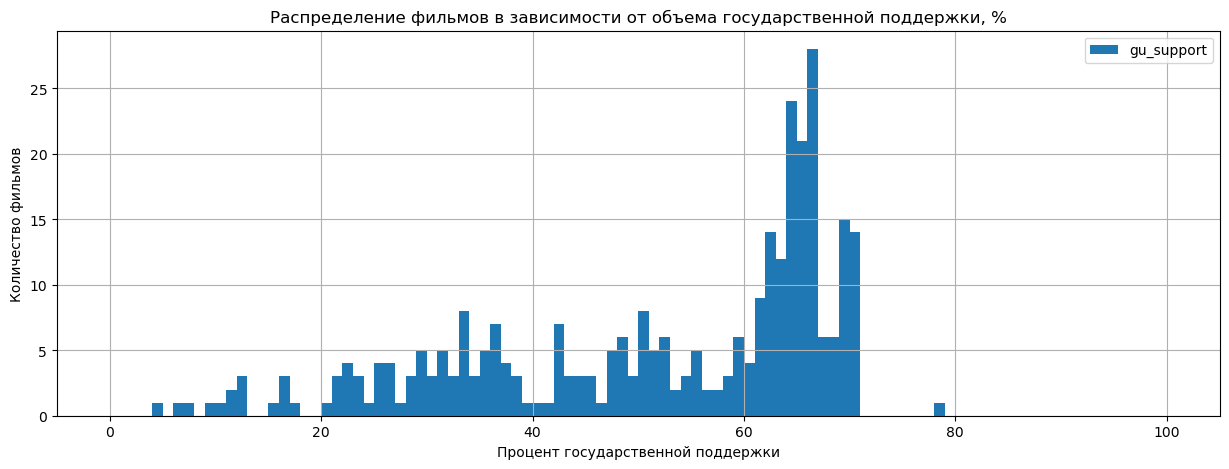

In [219]:
movies_total.plot(y='gu_support', kind='hist', bins=100, range=(0,100), grid=True, 
                  xlabel='Процент государственной поддержки', ylabel='Количество фильмов', 
                  title='Распределение фильмов в зависимости от объема государственной поддержки, %', figsize=(15,5));

In [221]:
movies_total.query('gu_support > 60')['gu_support'].count()

153

Большая часть фильмов, которая получала государственную поддержку, снималась, в основном, на эти деньги, так как размер поддержки составляет более 60 %.

### Исследовательский анализ данных

- Посмотрим, сколько фильмов выходило в прокат каждый год.
- Посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.
- Проанализируем, как эта доля менялась по годам.
- Сделаем вывод о том, какой период полнее всего представлен в данных.

In [226]:
rental_movies = movies_total.pivot_table(index='show_start_year', values=['rental'],aggfunc=['sum','count'])
rental_movies.columns = ['rental_count','total_movies']
rental_movies

,rental_count,total_movies
show_start_year,,
2010,105.00,789
2011,110.00,552
2012,126.00,524
2013,181.00,586
2014,274.00,737
2015,461.00,646
2016,508.00,653
2017,358.00,499
2018,474.00,886


Как видим, с 2015 года количество фильмов, получивших прокатное удостоверение, резко возрасло. Это связано, скорее всего, с тем, что с 1 июля 2014 года такое прокатное удостоверение стало обязательным.

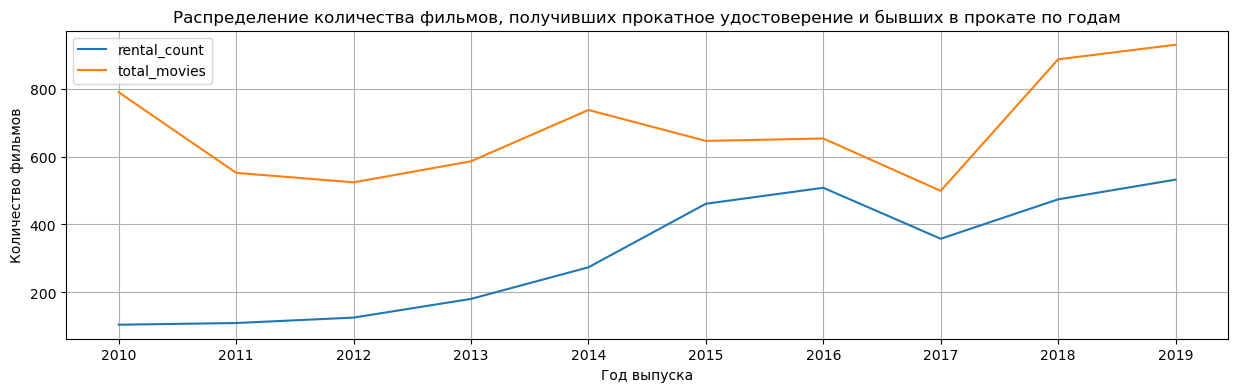

In [235]:
rental_movies.plot(grid=True,figsize=(15,4))
plt.xticks(rental_movies.index)
plt.xlabel('Год выпуска')
plt.ylabel('Количество фильмов')
plt.title('Распределение количества фильмов, получивших прокатное удостоверение и бывших в прокате по годам')
plt.legend(loc='best')
plt.show();

Начиная с 2014 года, количество снятых фильмов падает, однако, из-за обязательного наличия прокатного удостоверения количество фильмов, бывших в прокате растет, спад в 2017 год идет в параллели с общим количеством фильмов. В 2018 году можно отметить резкий рост количества выпускаемых фильмов, в прокат  фильмов поступает больше, чем 2017 году, но меньше, чем в 2016 году. Пиковыми значениями можем назвать 2019 год.

,rental_count,total_movies,rental_share
show_start_year,,,
2010,105.00,789,13.31
2011,110.00,552,19.93
2012,126.00,524,24.05
2013,181.00,586,30.89
2014,274.00,737,37.18
2015,461.00,646,71.36
2016,508.00,653,77.79
2017,358.00,499,71.74
2018,474.00,886,53.50


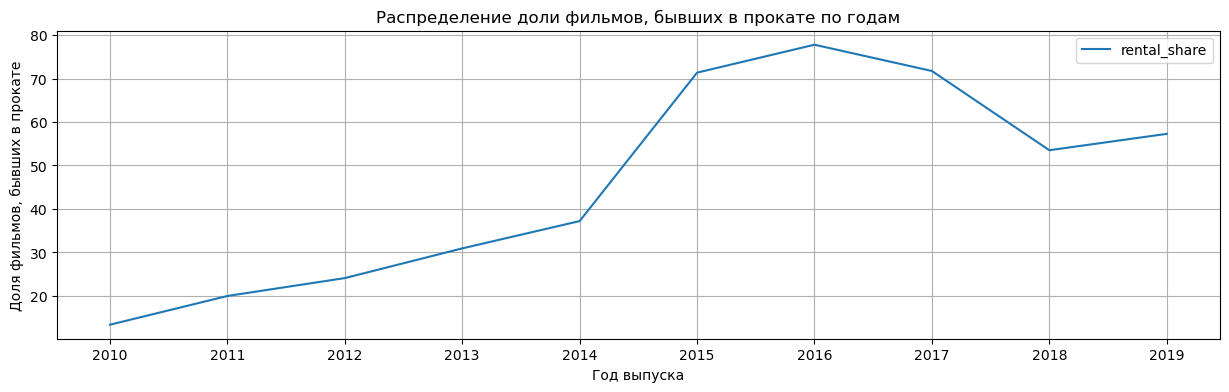

In [238]:
rental_movies['rental_share'] = rental_movies['rental_count'] / rental_movies['total_movies'] * 100
display(rental_movies)
rental_movies.plot(y='rental_share',grid=True,figsize=(15,4))
plt.xticks(rental_movies.index)
plt.xlabel('Год выпуска')
plt.ylabel('Доля фильмов, бывших в прокате')
plt.title('Распределение доли фильмов, бывших в прокате по годам')
plt.legend(loc='best')
plt.show();

Если смотреть долю фильмов, бывших в прокате по отношению к общему числу фильмов, вышедших за год, то 2015 - 2017 года являются пиковыми, в кинотеатрах показывалось более 70% фильмов, получивших прокатное удостоверение.

In [241]:
movies_total.pivot_table(index='show_start_year', values='rental', columns=['type','age_restriction'],aggfunc='sum')

type                                      Анимационный  \
age_restriction «0+» - для любой зрительской аудитории   
show_start_year                                          
2010                                             11.00   
2011                                             11.00   
2012                                             16.00   
2013                                             28.00   
2014                                             21.00   
2015                                             35.00   
2016                                             26.00   
2017                                              3.00   
2018                                              1.00   
2019                                              2.00   

type                                             \
age_restriction «12+» - для детей старше 12 лет   
show_start_year                                   
2010                                       6.00   
2011                                       2.00   
2012                                       6.00   
2013                                       1.00   
2014                                       0.00   
2015                                       4.00   
2016                                       3.00   
2017                                       2.00   
2018                                       5.00   
2019                                      10.00   

type                                                                         \
age_restriction «16+» - для детей старше 16 лет «18+» - запрещено для детей   
show_start_year                                                               
2010                                       0.00                         NaN   
2011                                       1.00                         NaN   
2012                                       1.00                        0.00   
2013                                       1.00                        1.00   
2014                                        NaN                         NaN   
2015                                       1.00                         NaN   
2016                                        NaN                        1.00   
2017                                       3.00                         NaN   
2018                                       2.00                        1.00   
2019                                       6.00                        2.00   

type                                           \
age_restriction «6+» - для детей старше 6 лет   
show_start_year                                 
2010                                      NaN   
2011                                     1.00   
2012                                     5.00   
2013                                     6.00   
2014                                     6.00   
2015                                    32.00   
2016                                    39.00   
2017                                    31.00   
2018                                    40.00   
2019                                    51.00   

type                                    Документальный  \
age_restriction «0+» - для любой зрительской аудитории   
show_start_year                                          
2010                                              0.00   
2011                                              3.00   
2012                                              1.00   
2013                                               NaN   
2014                                               NaN   
2015                                               NaN   
2016                                              6.00   
2017                                               NaN   
2018                                              1.00   
2019                                              1.00   

type                                             \
age_restriction «12+» - для детей старше 12 лет   
show_start_year                                   
2010   

В 2015 году мы видим резкий рост проката анимационных фильмов для детей с категорией 0+ ( в 2015 году стартовал проект "Мульт в кино") и 6+ (например, мультфильм "Головоломка"), а также художественных фильмов с категорией 16+ и 18+. 

- Изучим как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

In [244]:
box_rental = (
                movies_total
                .query('box_office>0')
                .pivot_table(index='show_start_year', values=['box_office'],
                             aggfunc=['sum'])
               )
box_rental.columns = ['box_sum']
box_rental.style.format("{:,.2f}")

,box_sum
show_start_year,
2010,"8,819,996.00"
2011,"16,128,501.00"
2012,"6,555,817.00"
2013,"29,773,046.20"
2014,"7,444,810,089.20"
2015,"38,717,942,108.80"
2016,"48,640,103,585.51"
2017,"48,561,189,113.51"
2018,"49,664,076,601.37"


Сумма сборов росли с 2014 по 2018 год, в 2019 наблюдается спад.

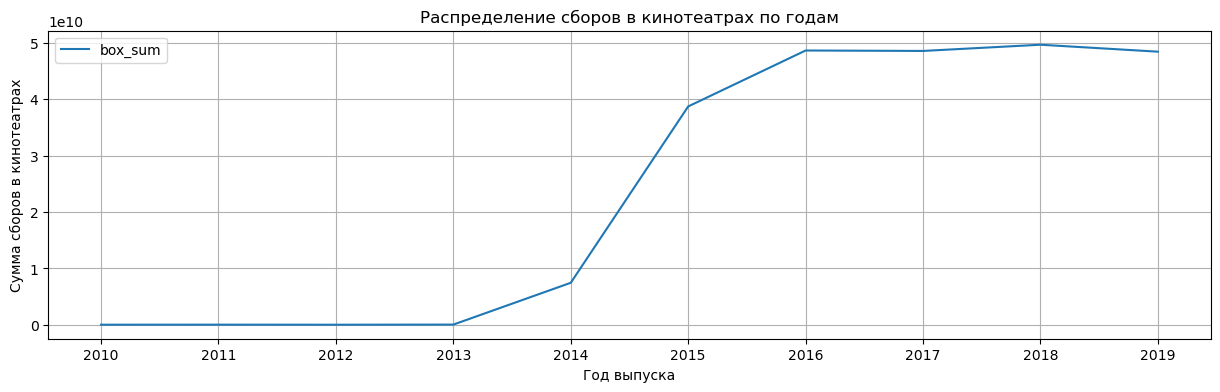

In [246]:
box_rental.plot(grid=True,figsize=(15,4))
plt.xticks(box_rental.index)
plt.xlabel('Год выпуска')
plt.ylabel('Сумма сборов в кинотеатрах')
plt.title('Распределение сборов в кинотеатрах по годам')
plt.legend(loc='best')
plt.show();

In [248]:
box_max = box_rental['box_sum'].max()
box_min = box_rental['box_sum'].min()
box = pd.DataFrame({'year':[box_rental['box_sum'].idxmax(),box_rental['box_sum'].idxmin()],
                    'box':[box_max,box_min], 
                    'type':['max','min']})
box = box.set_index('type')
box['year'] = box['year'].astype('int')
box.style.format({'box':'{:,.2f}'})

,year,box
type,,
max,2018,"49,664,076,601.37"
min,2012,"6,555,817.00"


- С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года.

In [250]:
box_rental_new = (
                  movies_total
                  .query('box_office>0')
                  .pivot_table(index='show_start_year', values=['box_office'],
                               aggfunc=['mean','median'])
                  )
box_rental_new.columns = ['box_mean','box_median']
box_rental_new.style.format("{:,.2f}")

,box_mean,box_median
show_start_year,,
2010,"87,326.69","2,260.00"
2011,"146,622.74","3,364.00"
2012,"54,180.31","5,760.00"
2013,"169,165.04","3,565.00"
2014,"27,779,142.12","23,752.50"
2015,"84,536,991.50","4,946,745.45"
2016,"95,937,087.94","4,692,814.90"
2017,"135,645,779.65","9,943,877.50"
2018,"104,776,532.91","8,911,533.94"


Мы видим большую разницу между средним и медианным значением, вполне возможно на медианное значение оказывают значение треть значений сборов, которые меньше 1 миллиона рублей.
А на высокое среднее значение — звезды кино, которые принесли млрд.

- Определим влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

In [255]:
age_box = (movies_total
           .query('box_office>0')
          .pivot_table(index='show_start_year',columns = ['age_restriction'], 
                       values=['box_office'],aggfunc=['sum'])
          .loc[2015:2019]
          )
age_box.columns = ['0+','12+','16+','18+','6+']
for column in ['0+','12+','16+','18+','6+']:   #сумму сборов выведем в миллионах рублей
    age_box[column] = age_box[column] / 1000000
age_box.style.format("{:,.2f}")

,0+,12+,16+,18+,6+
show_start_year,,,,,
2015,379.06,"13,616.08","10,798.79","5,222.21","8,701.80"
2016,150.53,"12,199.40","17,233.01","7,004.02","12,053.14"
2017,229.60,"7,851.43","18,742.52","9,651.50","12,086.14"
2018,32.45,"14,267.29","16,503.60","8,760.09","10,100.65"
2019,17.75,"12,680.20","12,753.42","10,121.80","12,857.16"


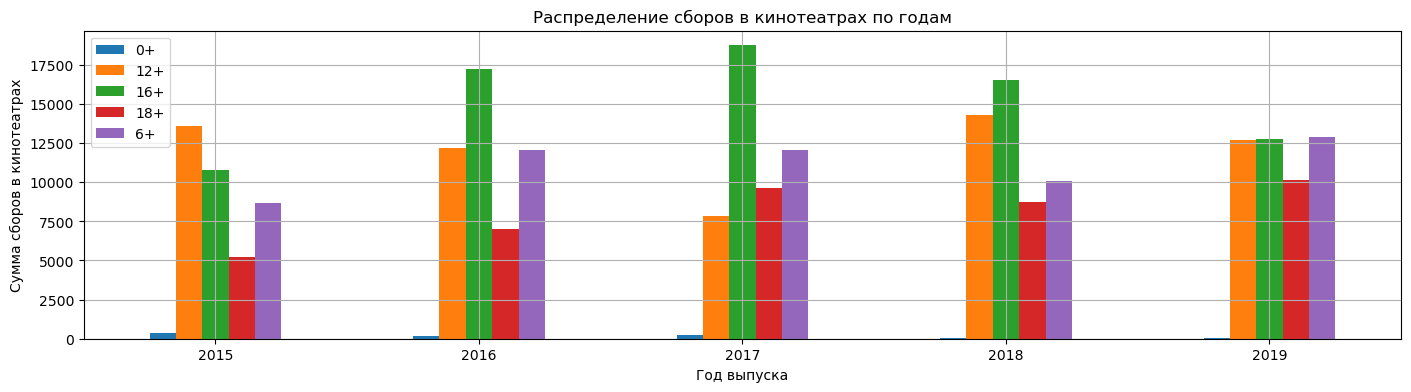

In [257]:
age_box.plot(kind='bar',grid=True,figsize=(17,4))
plt.xlabel('Год выпуска')
plt.ylabel('Сумма сборов в кинотеатрах')
plt.title('Распределение сборов в кинотеатрах по годам')
plt.legend(loc='best');
plt.xticks(np.arange(len(age_box)), age_box.index,rotation=0)
plt.show();

In [259]:
age_rental = (
              movies_total
              .query('box_office > 0')
              .pivot_table(index='show_start_year',columns = ['age_restriction'], 
                           values=['rental'],aggfunc=['sum'])
              .loc[2015:2019]
              )
age_rental.columns = ['0+','12+','16+','18+','6+']

age_rental

,0+,12+,16+,18+,6+
show_start_year,,,,,
2015,37.00,72.00,166.00,130.00,53.00
2016,41.00,77.00,173.00,150.00,66.00
2017,3.00,42.00,120.00,148.00,45.00
2018,5.00,67.00,156.00,179.00,67.00
2019,3.00,85.00,178.00,183.00,83.00


In [261]:
age_box_mean = age_box
for column in ['0+','12+','16+','18+','6+']:
        age_box_mean[column] = age_box[column] / age_rental[column]
age_box_mean

,0+,12+,16+,18+,6+
show_start_year,,,,,
2015,10.24,189.11,65.05,40.17,164.18
2016,3.67,158.43,99.61,46.69,182.62
2017,76.53,186.94,156.19,65.21,268.58
2018,6.49,212.94,105.79,48.94,150.76
2019,5.92,149.18,71.65,55.31,154.91


Начиная с 2016 года, лидером проката являются фильмы с ограничением "16+", под это возрастное ограничение попадает большинство фильмов, находящихся в прокате, немного уступая в 2017-2019 году фильмам с ограничением "18+".Сумма сборов при этом значительно превышает сборы фильмов "18+", что возможно объяснимо более активным посещением кинотеатров подростков. В 2015 году наибольшую сумму сборов получили фильмы с ограничением "12+".

При этом наибольшими средними сборами обладают фильмы категории "6+" и "12+", фильмы категории "16+" являются третьими в списке лидеров по средним сборам.

### Исследуем фильмы, которые получили государственную поддержку

In [265]:
movies_supported = movies_total.query('support > 0 & box_office >0')

movies_supported.pivot_table(index='show_start_year', values=['support','box_office','budget'],aggfunc=['sum']).style.format("{:,.2f}")

Мы видим, что фильмы, получившие государственную поддержку, начиная с 2014 года, поддкржку окупили, но не весь бюджет фильма. Фильмы полностью себя окупают только в 2017 и 2018 годах. Посмотрим, какой рейтинг имеют эти фильмы в среднем.

In [268]:
movies_supported.pivot_table(index='show_start_year', values='ratings')

,ratings
show_start_year,
2013,6.70
2014,6.01
2015,6.06
2016,5.65
2017,5.99
2018,6.00
2019,6.23


Как видим, фильмы, имеющие государственную поддержку, получали не очень высокий рейтинг, в среднем около 6.

Проверим, фильмы какого жанра получали больше господдержки.

In [271]:
movies_supported.pivot_table(index='main_genre',values=['support','ratings']).sort_values(by='support', ascending=False).style.format("{:,.2f}")

,ratings,support
main_genre,,
история,5.35,"255,000,000.00"
спорт,6.93,"151,666,666.67"
приключения,5.75,"110,166,666.67"
детектив,6.76,"97,000,000.00"
фэнтези,6.09,"93,900,000.00"
криминал,7.50,"93,333,333.33"
фантастика,5.83,"90,600,000.00"
мультфильм,5.76,"81,666,666.67"
мюзикл,6.55,"60,113,279.75"


Топ-три жанра по среднему финансированию : исторический фильм, спорт и фантастика. При этом наивысшие рейтинги получают детские и криминальные фильмы. Детские фильмы занимают второе место с конца по  государственной поддержке.

In [276]:
movies_supported.pivot_table(index='show_start_year',columns='financing_source',
                             values=['ratings','box_office','budget','support']).style.format("{:,.2f}")

С 2014 года складывается следующая картина: Фонд Кино оказывает значительную финансовую поддержку кинематографу, и фильмы, 
получившие такую поддержку имеют в среднем больше сборов, чем фильмы, получившие поддержку от Министерства культуры или совместно
от Министерства и Фонда.Рейтинг этих фильмов, однако, ниже, чем у фильмов, получивших поддержку от Министерства культуры и Фонда кино.

In [278]:
movies_supported[['box_office', 'rental']][(movies_supported['box_office'] == 0)]

,box_office,rental


In [286]:
(movies_supported.pivot_table(index='first_director',values=['ratings','box_office','support','budget'])
 .sort_values(by='box_office', ascending=False).head(10).style.format("{:,.2f}"))

,box_office,budget,ratings,support
first_director,,,,
А.Мегердичев,"2,779,686,144.00","590,192,191.00",7.50,"400,000,000.00"
А.Сидоров,"2,271,754,004.52","563,784,717.00",6.50,"180,000,000.00"
О.Трофим,"1,445,731,797.89","148,585,222.00",nan,"85,000,000.00"
Н.Лебедев,"1,402,255,390.00","635,283,867.00",7.60,"442,104,482.00"
К.Шипенко,"1,275,924,072.60","234,976,889.33",6.83,"104,000,000.00"
Ф.Бондарчук,"1,038,321,489.00",nan,5.60,"250,000,000.00"
Д.Козловский,"820,528,005.21","390,191,139.00",6.80,"260,000,000.00"
К.Феоктистов,"759,226,773.00","174,464,395.00",5.50,"50,000,000.00"
А.Кравчук,"717,703,185.53","980,000,000.00",6.00,"500,000,000.00"


Мы получили топ-10 режиссеров, получивших господдержку и обеспечивших большие кассовые сборы.

### Общий вывод

Нам нужно проанализировать данные по фильмам, получившим прокатное удостоверение с 2013 по 2019 год, а также по фильмам, бывшим в прокате в этот период.

В обеих таблицах есть столбец `puNumber`, который мы переименовали в `pu_number`. 

В этом столбце мы обнаружили два дубликата номера прокатного удостоверения, мы поправили повторяющийся номер, сохранив исходный внутри нового, так что эти номера визуально заметны.

Объединили таблицы по данному столбцу, предварительно приведя его к одному типу. После объединения все строки из таблицы mkrf_movies вошли в объдиненную таблицу.

Проверив типы столбцов в получившейся таблице movies_total, видим, что стоит изменить тип данных в двух столбцах `show_start_date` и `ratings`.

Cреди значений столбца `ratings` появляются значения в процентах, мы не знаем как именно взаимосвязаны значение рейтинга и проценты, поэтому изменили тип столбца на float, при этом некорректные значения (в процентах) заменили на NaN.

Проверив столбцы на пропуски, обнаружили, что пропуски есть в столбцах `production_country` (всего два пропуска, заменили на 'Россия'), `director`, `film_studio`, `producer`, `genres` (здесь пропуски заменили на строку 'unknown'), в столбце `financing_source` (заменили на пустую строку). Пропуски в столбцах `box_office`,`refundable_support`, `nonrefundable_support` и `budget` не заполняем, так как изначально здесь данные только по тем фильмам, которые получили государственную поддержку.

Явных дубликатов в данных нет, но мы видели, что в таблице есть строки, в которых совпадают название фильма, режиссер, продюсер, студия и страна-производитель, рейтинг, бюджет, объем государственной поддержки, есть различия в номере прокатного удостоверения, даты премьерного показа и суммы сборов. Таким  образом, мы имеем неявные дубликаты. Возможно, что они появились из-за того, что фильм несколько раз получал прокатное удостоверение (в случае окончания действия одного и получения нового, либо при изменении правообладателя). Тогда при удалении дубликатов мы должны просуммировать суммы сборов, так как они относятся к конкретному прокатному удостоверению.

Для того, чтобы удалить неявные дубликаты, мы создали новый столбец `hash`, в котором указана уникальная информация 
по фильму: название, тип фильма, студия-производитель, страна-производитель, режиссер, продюссер и жанр. При создании этого столбца мы перевели данные в нижний регистр, убрали пробелы, точки, подчеркивания и восклицательные знаки как вначале каждого элемента так и в конце и склеили все в одну строку.

Также создали столбец `rental`показывающий был фильм в прокате (есть сумма сборов) или нет: если фильм был в прокате, то значение 1, если нет - то 0.
Удалили дубликаты по столбцу `hash`.

В столбцах со строковыми данными легко можно поставить лишний пробел в начале или конце строки, визуально это будет не заментно, но скажется на данных. Поэтому, уберем пробелы в значениях категориальных столбцов .

В количественных столбцах `refundable_support`, `nonrefundable_support`, `budget`, `box_office` даны значения в рублях.  В столбце `budget` указан полный объем государственной поддержки, поэтому значения в этом столбце должны быть больше или равны сумме значений столбцов `refundable_support` и `nonrefundable_support`. Заменим значение в столбце `budget` в строках, в которых не выполняется данное условие.

Большинство фильмов, получивших разного вида поддержку получили до 50 миллионов как возвратной так и невозвратной поддержки. 

Фильмы, получившие невозвратную господдержку в размере более 200 миллионов рублей, которая перекрывает больше половины бюджета, профинансированы Фондом кино.

Государственная поддержка оказывалась разным фильмам, при этом большая часть фильмов получила поддержку в размере больше 60% от бюджета фильма.

Начиная с 2014 года, количество снятых фильмов падает, что не отражается на  количестве фильмов, бывших в прокате (здесь все равно идет рост количества фильмов, спад в 2017 год идет в параллели с общим количеством фильмов). В 2018 году можно отметить резкий рост количества выпускаемых фильмов, но в прокат  фильмов поступает больше, чем 2017 году, но меньше, чем в 2016 году. 

В 2015 году мы видим резкий рост проката анимационных фильмов для детей с категорией 0+ ( в 2015 году стартовал проект "Мульт в кино") и 6+ (например, мультфильм "Головоломка"), а также художественных фильмов с категорией 16+ и 18+. 

Сумма сборов росли с 2014 по 2018 год, в 2019 наблюдается спад. Наибольшие сборы были в 2018 году, а наименьшие в 2012 году. 

Мы видим большую разницу между средним и медианным значением, вполне возможно на медианное значение оказывают значение треть значений сборов, которые меньше 1 миллиона рублей.

Начиная с 2016 года, лидером проката являются фильмы с ограничением "16+", под это возрастное ограничение попадает большинство фильмов, находящихся в прокате, немного уступая в 2017-2019 году фильмам с ограничением "18+".Сумма сборов при этом значительно превышает сборы фильмов "18+", что возможно объяснимо более активным посещением кинотеатров подростков. В 2015 году наибольшую сумму сборов получили фильмы с ограничением "12+".

Фильмы, получившие государственную поддержку, начиная с 2014 года, поддержку окупили, но не весь бюджет фильма. Фильмы полностью себя окупают только в 2017 и 2018 годах. Фильмы, имеющие государственную поддержку, получали не очень высокий рейтинг, в среднем около 6.

Топ-три жанра по среднему финансированию : исторический фильм, спорт и приключения. При этом наивысшие рейтинги получают детские, спортивные и криминальные фильмы. Детские фильмы занимают второе место с конца по  государственной поддержке.

С 2014 года складывается следующая картина: Фонд Кино оказывает значительную финансовую поддержку кинематографу, и фильмы, 
получившие такую поддержку имеют в среднем больше сборов, чем фильмы, получившие поддержку от Министерства культуры или совместно от Министерства и Фонда.Рейтинг этих фильмов, однако, ниже, чем у фильмов, получивших поддержку от Министерства культуры и Фонда кино.

Мы получили топ-10 режиссеров, получивших господдержку и обеспечивших большие кассовые сборы.